# Introduction to the `Catalog` classes in `orpheus`

In this notebooks we introduce the different tracer categories in `orpheus` and how to construct reduced catalogs. 

## Basics
Currently, in `orpheus` we have implemented the following classes for tracer catalogs:

##### The `Catalog` class
This is the parent class from which the more specific catalog classes are derived. It only requires the spatial positions of the data of any catalog and contains the implementations for common operations, such as the reduction of catalogs in pixels, the creation of hierarchical spatial hashes, as well as the empirical estimation of anglular masks.

##### The `ScalarTracerCatalog` class
This is what you want to use for scalar tracers, such as the weak lensing convergence field. In case you really only want to use (weighted) number counts you can set the `tracer` to equal to unity.

##### The `SpinTracerCatalog` class
This is what you want to use for tracers with a directional dependence, such as the spin-2 weak lensing shear field. In case you really only want to use (weighted) number counts you can set the `tracer` to equal to unity. The spin of the (complex-valued) tracer is explicitly passed via the `spin` attribute.

In [1]:
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt

import orpheus

## Obtaining a realistic mock shape catalog

We will run this notebook using a mocks shape catalog from the SLICS ensemble. First, let us download this catalog and read in its contents.

**Note:** If you want to run the notebook yourself, you need to update the `savepath_SLICS` variable.

In [2]:
catname = "GalCatalog_LOS1.fits"
path_to_SLICS = "http://cuillin.roe.ac.uk/~jharno/SLICS/MockProducts/KiDS450/" + catname
savepath_SLICS = "/vol/euclidraid4/data/lporth/HigherOrderLensing/Mocks/SLICS_KiDS450/"

In [ ]:
!wget {path_to_SLICS} -P {savepath_SLICS}

In [3]:
slicscat = Table.read(savepath_SLICS + catname)
print(slicscat.keys())

['x_arcmin', 'y_arcmin', 'z_spectroscopic', 'z_photometric', 'shear1', 'shear2', 'eps_obs1', 'eps_obs2']


To make things slightly more realistic, let us apply a simplistic angular survey mask where we cut out a bunch of poissonian distributed rectangular shapes of varying sizes

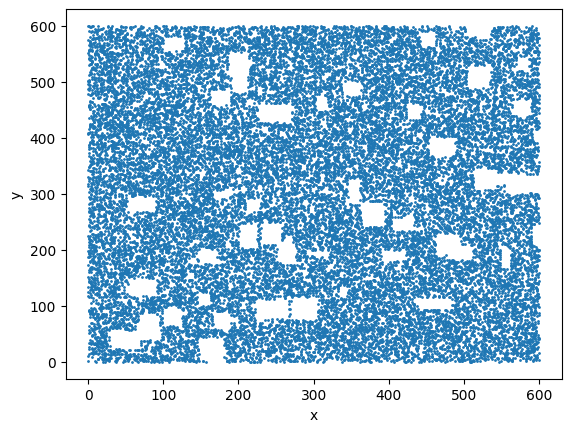

In [4]:
nmask = 50
length_mean = 30
lenght_std = 10
rseed = 42

sx = 600*np.random.rand(nmask)
sy = 600*np.random.rand(nmask)
np.random.seed(rseed)
lx = np.abs(np.random.normal(loc=length_mean,scale=lenght_std,size=nmask))
ly = np.abs(np.random.normal(loc=length_mean,scale=lenght_std,size=nmask))

unmasked = np.ones(len(slicscat['x_arcmin']), dtype=bool)
for imask in range(nmask):
    nextmask = np.ones(len(slicscat['x_arcmin']), dtype=bool)
    nextmask *= (slicscat['x_arcmin']>sx[imask]) * (slicscat['x_arcmin']<(sx[imask]+lx[imask])) 
    nextmask *= (slicscat['y_arcmin']>sy[imask]) * (slicscat['y_arcmin']<(sy[imask]+ly[imask])) 
    unmasked *= ~nextmask

plt.scatter(slicscat['x_arcmin'][unmasked][::100],slicscat['y_arcmin'][unmasked][::100],s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Initializing a `SpinTracerCatalog` instance

As we are dealing with an ellipticity catalog, we need to use the `SpinTracerCatalog` class and set the value of `spin` to two.


In [5]:
shapecat = orpheus.SpinTracerCatalog(spin=2,
                                     pos1=slicscat["x_arcmin"][unmasked],
                                     pos2=slicscat["y_arcmin"][unmasked],
                                     tracer_1=slicscat["shear1"][unmasked],
                                     tracer_2=slicscat["shear2"][unmasked])

Looking at the ``__dict__`` of the instance, we see that there are a bunch of more attributes have been allocated. Many of those can be set adjusted in the `__init__` and are directly inherited from the parent `Catalog` class. But let's keep things simple here.

In [6]:
for i, (k, v) in enumerate(shapecat.__dict__.items()):
    if isinstance(v,np.ndarray):
        print(k,v.shape)
    else:
        print(k,v)

pos1 (2750214,)
pos2 (2750214,)
weight (2750214,)
zbins (2750214,)
ngal 2750214
nbinsz 1
isinner (2750214,)
units_pos1 None
units_pos2 None
geometry flat2d
mask None
zbins_mean None
zbins_std None
min1 1.0337681e-05
min2 4.8615038e-05
max1 599.99976
max2 599.99988
len1 599.999749662319
len2 599.9998313849619
spatialhash None
hasspatialhash False
index_matcher None
pixs_galind_bounds None
pix_gals None
pix1_start None
pix1_d None
pix1_n None
pix2_start None
pix2_d None
pix2_n None
patchinds None
assign_methods {'NGP': 0, 'CIC': 1, 'TSC': 2}
library_path /users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages
clib <CDLL '/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/orpheus_clib.cpython-312-x86_64-linux-gnu.so', handle 34b979b0 at 0x761042a2f4d0>
tracer_1 (2750214,)
tracer_2 (2750214,)
spin 2


## Reducing the catalog

Coarse-grains the tracers using a regular grid. This method is implicitly used when creating a hierarchical spatial hash, but one can also use it as a pre-processing step to reduce the number of tracers before inferring some summary statistic. <br>
Note that the `reduce` method does _not_ place the catalog on a regular grid and does not return this as a 2d array, but instead either returns a suite of numpy nd arrays (default) or directly puts those into a corresponding catalog instance (for this set `ret_inst=True`).<br>

We further allow for multiple options on where within the pixels to put the tracers:
* 0 --> Use center of mass. This is set as default
* 1 --> Do a random shift within the pixel. <br> This does artificially add poisson noise to the couse-grained field which for estimates of large multipoles of the _N_ PCF gives lower ringing effects
* 2 --> Use the pixel center
* 3 --> Use the position of the tracer with the largest weight

The following images showcase a few oth those choices and for visual purposes we set a fairly large pixelsize.

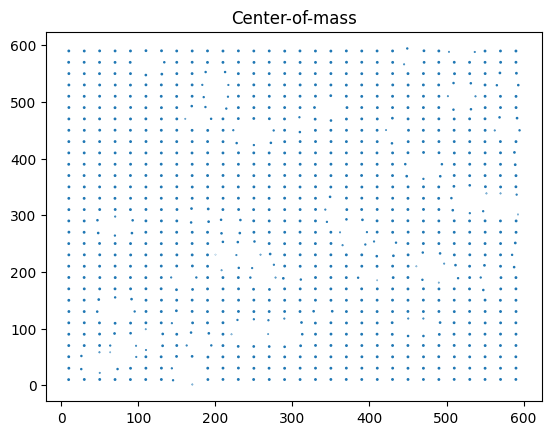

Arrays agree? True True True


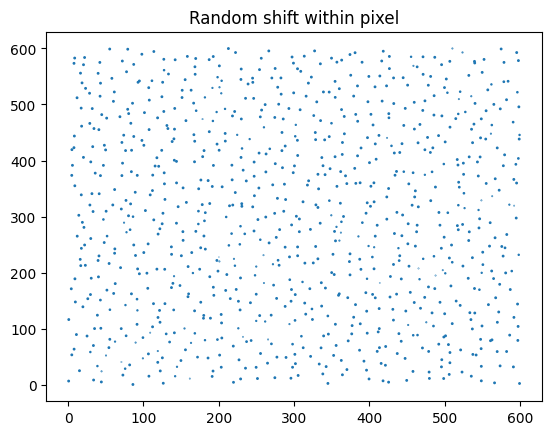

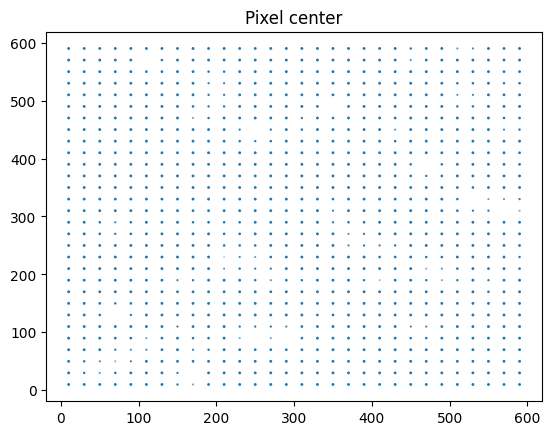

In [7]:
# Use center-of-mass. Size of points correspond to relative overdensity -- this is lower when the pixel intersects with a masked region
w_red, pos1_red, pos2_red, zbins_red, isinner_red, fields_red = shapecat.reduce(dpix=20., shuffle=0)
plt.scatter(pos1_red, pos2_red,s=w_red/np.mean(w_red))
plt.title('Center-of-mass')
plt.show()

# Same as above, but return as catalog instance. Check that both results are equivalent
red_cat = shapecat.reduce(dpix=20., shuffle=0, ret_inst=True)
print('Arrays agree?',np.array_equal(red_cat.pos1,pos1_red),np.array_equal(red_cat.pos2,pos2_red),np.array_equal(red_cat.weight,w_red))

# Use random shift within the pixel
w_red, pos1_red, pos2_red, zbins_red, isinner_red, fields_red = shapecat.reduce(dpix=20., shuffle=1)
plt.scatter(pos1_red, pos2_red,s=w_red/np.mean(w_red))
plt.title('Random shift within pixel')
plt.show()

# Use the pixel center
w_red, pos1_red, pos2_red, zbins_red, isinner_red, fields_red = shapecat.reduce(dpix=20., shuffle=2)
plt.scatter(pos1_red, pos2_red,s=w_red/np.mean(w_red))
plt.title('Pixel center')
plt.show()

## Constructing a (hierarchical) spatial hash

This is the main method `orpheus` uses for a quick range search operation. Here we just want to give some intuition of what this hash looks like -- for the nitty gritty details please refer to the actual implementation. A single not worth making is that for a _tomographic_ setup, we need to compute a separate hash for each tomographic bin.

In case a spatial hash is wanted for another application it can easily be constructed from the python layer using the `multihash` method. The main arguments that enter are the different pixel sizes of the hash (need to be multiples of two) as well as the `shuffle` parameter that we already encountered in the `reduce` method. <br>
The function then retuns a number of arrays from which a fast search can be constructed.

In [8]:
resos = [0.25,0.5,1.,2.,4.,8.]
hierarchical_hash = shapecat.multihash(dpixs=[0.25,0.5,1.,2.,4.,8.],shuffle=0)
ngals, pos1s, pos2s, weights, zbins, isinners, allfields, index_matchers, pixs_galind_bounds, pix_gals, dpixs1_true, dpixs2_true = hierarchical_hash

At first, let us have a quick look on what the hash achieved, i.e. how many galaxies are in the various reduced catalogs and how close the actual pixel size is the the target one (small discrepancies can happen to make the pixels evenly divide the extent of the survey footprint).

In [9]:
print('Galaxies per hash resolution: ',ngals)
print('True pixel sizes per resolution: ',dpixs1_true,dpixs2_true)

Galaxies per hash resolution:  [2750214, 2131981, 1138052, 324225, 81769, 20686, 5303]
True pixel sizes per resolution:  [0.2499999  0.4999998  0.9999996  1.99999921 3.99999842 7.99999683] [0.24999993 0.49999987 0.99999973 1.99999947 3.99999893 7.99999787]


Now let us make a visualize the tracers that reside in each resolution of the catalog. For this we pick a single region that matches the size of the coarses cell-size in the hash. In the figure we further show the weight of each pixel as the size of each dot.

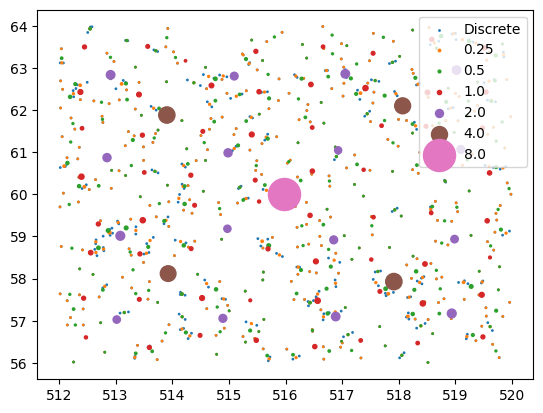

In [10]:
# The index of the spatial hash cell we are interested in
hash_target = 777 

for elreso in range(7):
    if elreso==0:
        label='Discrete'
    else:
        label = resos[elreso-1]
    # Get the first and last indices of the galaxies within the pixel of the hash
    galind_bound_start = pixs_galind_bounds[elreso][index_matchers[elreso][hash_target]]
    galind_bound_end =  pixs_galind_bounds[elreso][index_matchers[elreso][hash_target]+1]
    # Retrieve those indices from the hierarchy of reduced catalogs
    galinds_elreso = pix_gals[elreso][galind_bound_start:galind_bound_end]
    plt.scatter(pos1s[elreso][galinds_elreso],pos2s[elreso][galinds_elreso],s=weights[elreso][galinds_elreso],label=label)
plt.legend(loc=1)
plt.show()

## Building a mask

Methods such as the direct estimator require the specification of a survey mask based on the passed catalog. You can create such a mask using the `create_mask` method. Here we show three examples how this could be done.

* Choose the default option <br>
--> This assumes no mask whatsoever and stores the mask values over the extent of the catalog. One can extend the maske over a larger range by setting the `extend` parameter.

* Reconstruct the mask from the observed tracers using `method='Density'` <br>
--> This first pixelizes the catalog and then assumes that empty pixels are masked.

* Reconstruct the mask from the observed tracers and additionally adjust the pixel size of the mask using the `pixsize` parameter <br>
--> Here you need to be careful to not choose the pixelsize too small as otherwise the density-based methods wrongly inferrs a mask in underdense regions. <br> 
--> The default value is `pixsize=1.0` which for most lensing applications gives a decent reconstruction if the units of the data are given in arcminutes.

Masked fraction: 0.640


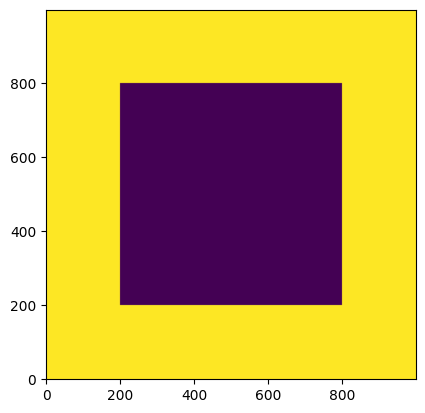

Masked fraction: 0.353


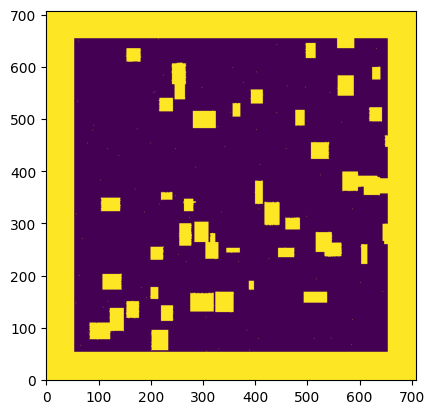

Masked fraction: 0.730


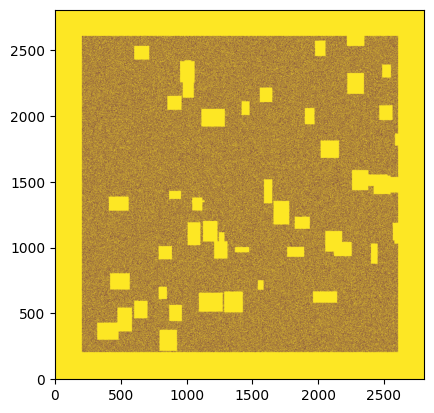

In [11]:
shapecat.create_mask(extend=200)
plt.imshow(shapecat.mask.data,origin='lower')
print('Masked fraction: %.3f'%np.mean(shapecat.mask.data))
plt.show()


shapecat.create_mask(method='Density',extend=50)
plt.imshow(shapecat.mask.data,origin='lower')
print('Masked fraction: %.3f'%np.mean(shapecat.mask.data))
plt.show()

shapecat.create_mask(method='Density',pixsize=0.25,extend=50)
plt.imshow(shapecat.mask.data,origin='lower')
print('Masked fraction: %.3f'%np.mean(shapecat.mask.data))
plt.show()